## Analyzing Large Datasets with Pandas

Pandas simplifies the analysis of large datasets. In this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library, to learn about some of Pandan's capabilities. 


The Titanic dataset is a well-known dataset that contains information such as passengers' gender, age, class, fare paid, survival status, and much more. 

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [14]:
# You can take a peek at the start of the data with the .head() function. This action allows you to see the columns and type of data you are dealing with
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


- pclass: Passenger Class
- sibsp: Number of siblings/spouses aboard the Titanic
- parch: Number of parents/children aboard the Titanic

In [15]:
#you can take a peek at the end of the data with the .tail() function
titanic.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


In [16]:
#you obtain a quick summary of the numeric columns in your data using .describe() 
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
You can use the ``GroupBy`` operation–for example, let's look at the survival rate by gender:

In [17]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [18]:
titanic.groupby(['sex', 'class'], observed=True)['survived'].mean().unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``:

In [21]:
titanic.pivot_table('survived', index='sex', columns='class', observed=True)

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the ``groupby`` approach, and produces the same result.


### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.

We'll bin the age using the ``pd.cut`` function, which identifies the age range of each passenger, [0, 18] or (18,80]

In [23]:
age = pd.cut(titanic['age'], [0, 18, 80])
print(age)

0      (18.0, 80.0]
1      (18.0, 80.0]
2      (18.0, 80.0]
3      (18.0, 80.0]
4      (18.0, 80.0]
           ...     
886    (18.0, 80.0]
887    (18.0, 80.0]
888             NaN
889    (18.0, 80.0]
890    (18.0, 80.0]
Name: age, Length: 891, dtype: category
Categories (2, interval[int64, right]): [(0, 18] < (18, 80]]


In [24]:
titanic.pivot_table('survived', ['sex', age], 'class', observed=True)

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [25]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'], observed=True)

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

The result is a four-dimensional aggregation with hierarchical indices, shown in a grid demonstrating the relationship between the values.

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [26]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':'sum', 'fare':'mean'}, observed=True)

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [27]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True, observed=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

## Exercise

Next, you will use your Pandas skills to analyze a new dataset. The data is related to births in the United States, provided by the Centers for Disease Control (CDC). 

This data has been studied extensively, and there are several websites describing methods for its analysis. 

Try to do the following analysis yourself. If you get stuck, the full solution is at the end of the notebook. 

In [31]:
# Let's start by reading the data and looking at it
births_data = pd.read_csv('data/births.csv', index_col = None)
print(len(births_data))

15547


This data contains many outliers caused by typos. One way to remove outliers is to use sigma clipping, which uses the 25th, 50th, and 75th percentiles of the data. The methods can be used as follows:

```Python
quartiles = np.percentile(births_data['births'],[25,50,75]) # compute the 25th, 50th, and 75th percentiles
mu = quartiles[1] #get the 50th percentile (median)
sigma = 0.74 * (quartiles[2] - quartiles[0]) # compute the sigma threshold
births_data = births_data.query('(births > @mu - 5 * @sigma) & (births < @mu + 5 * @sigma)')
```

In [32]:
#write your code to eliminate outliers here
quartiles = np.percentile(births_data['births'],[25,50,75]) # compute the 25th, 50th, and 75th percentiles
mu = quartiles[1] #get the 50th percentile (median)
sigma = 0.74 * (quartiles[2] - quartiles[0]) # compute the sigma threshold
births_data = births_data.query('(births > @mu - 5 * @sigma) & (births < @mu + 5 * @sigma)')
print(len(births_data))

14610


In [33]:
#print the head of the data to get an idea of what it contains

#write your code here
births_data.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [34]:
#print the tail of the data to get an idea of what it contains

#write your code here
births_data.tail()

,year,month,day,gender,births
15062,1988,12,29.0,M,5944
15063,1988,12,30.0,F,5742
15064,1988,12,30.0,M,6095
15065,1988,12,31.0,F,4435
15066,1988,12,31.0,M,4698


as you can see, the data contains the number of births (both Male (M) and Female (F)) from 1969 until 1988. Some of the data is arranged by days, and other is by months. 

In [36]:
#summarize the total number of births per year (both M and F) using a pivot table 
#write your code here
births_data.pivot_table('births', index = 'year', columns = 'gender', aggfunc = 'sum', observed=True)

gender,F,M
year,,
1969,1752836,1845742
1970,1817562,1917044
1971,1736556,1826518
1972,1592159,1673704
1973,1532859,1612811
1974,1542868,1627438
1975,1535444,1617922
1976,1547508,1628758
1977,1623307,1708741


This large table is difficult to read, create a visual representation of the data by adding ```.plot()``` after you create your pivot_table

<Axes: xlabel='year'>

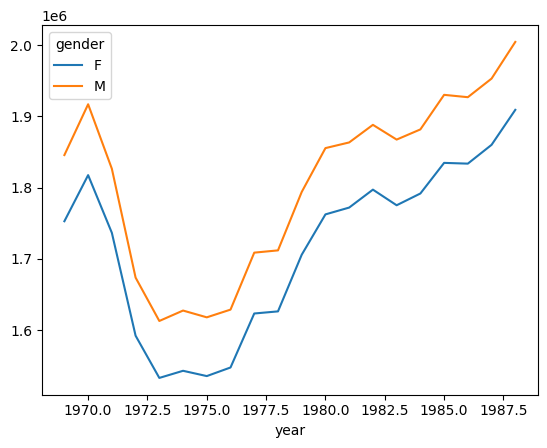

In [37]:
#write your code here
births_data.pivot_table('births', index = 'year', columns = 'gender', aggfunc = 'sum', observed=True).plot()

Using this plot, is easy to see that the has been more male birth than female births in the US. And that the number of births shows a growing trend. 

Try it yourself. If you get stuck, the solution is at the end of the notebook. 

|

|

|

|

|

|

|

|

|

|

|

|

|

|

Are you sure you want to see the answer?

|

|

|

|

|

|

|

|

|

|

|

|

|

|

ok....

In [ ]:
#write your code to eliminate outliers here
quartiles = np.percentile(births_data['births'],[25,50,75]) # compute the 25th, 50th, and 75th percentiles
mu = quartiles[1] #get the 50th percentile (median)
sigma = 0.74 * (quartiles[2] - quartiles[0]) # compute the sigma threshold
births_data = births_data.query('(births > @mu - 5 * @sigma) & (births < @mu + 5 * @sigma)')

In [ ]:
#print the head of the data to get an idea of what it contains

#write your code here
births_data.head()

In [ ]:
#print the tailof the data to get an idea of what it contains

#write your code here
births_data.tail()

In [ ]:
#summarize the total number of births per year (both M and F) using a table 

#write your code here
births_data.pivot_table('births', index='year', columns = 'gender', aggfunc = 'sum')

In [ ]:
#write your code here
births_data.pivot_table('births', index='year', columns = 'gender', aggfunc = 'sum').plot()